# Simulation of data

In [ ]:
# simulation of data Y = f(X) + epsilon
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt; plt.set_cmap('Set1')
% matplotlib inline

In [104]:
a, b = 0, 1 # interval [0, 1]
n = 200 # size of data

# noise simulation
lmbd_int = .8 ** 2 # medium noise level
norm_rv = sts.norm(2, 0.4)
sigma = np.diag(lmbd_int * np.sort(norm_rv.rvs(n) ** 2)) # covariance matrix of epsilon
epsilon = sts.multivariate_normal(cov=sigma).rvs()

$$
f(x) = c_0 + \sum_{j = 1}^{\lfloor n / 2 \rfloor} c_{2j - 1} \sin(2 \pi j x) + c_{2j} \cos(2 \pi j x),
$$

In [105]:
# f(X)
norm_rv = sts.norm(0, 1)
basis_coef = np.zeros(n + 1)
basis_coef[:10] = norm_rv.rvs(10)
basis_coef[10:-1] = norm_rv.rvs(n - 10) / np.array([(j - 10) ** 2 for j in range(11, n + 1)])

def f(x):
    res = basis_coef[0]
    for j in range(1, n // 2 + 1):
        res += basis_coef[2 * j - 1] * np.sin(2 * np.pi * j * x / (b - a))
        res += basis_coef[2 * j] * np.cos(2 * np.pi * j * x / (b - a))
    return res

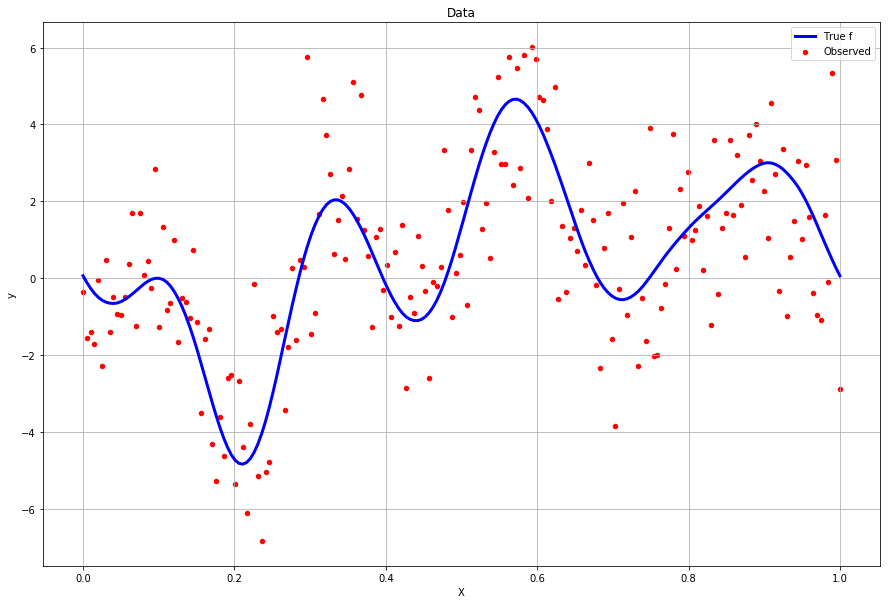

In [119]:
X = np.linspace(a, b, n)
y = f(X) + epsilon
plt.figure(figsize=(15, 10))
plt.scatter(X, y, label='Observed', s=20, c='r')
plt.plot(X, f(X), label='True f', lw=3, c='b')
plt.grid()
plt.title('Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

# B-splines

In [130]:
from scipy.interpolate import *

Text(0.5,0,'x')

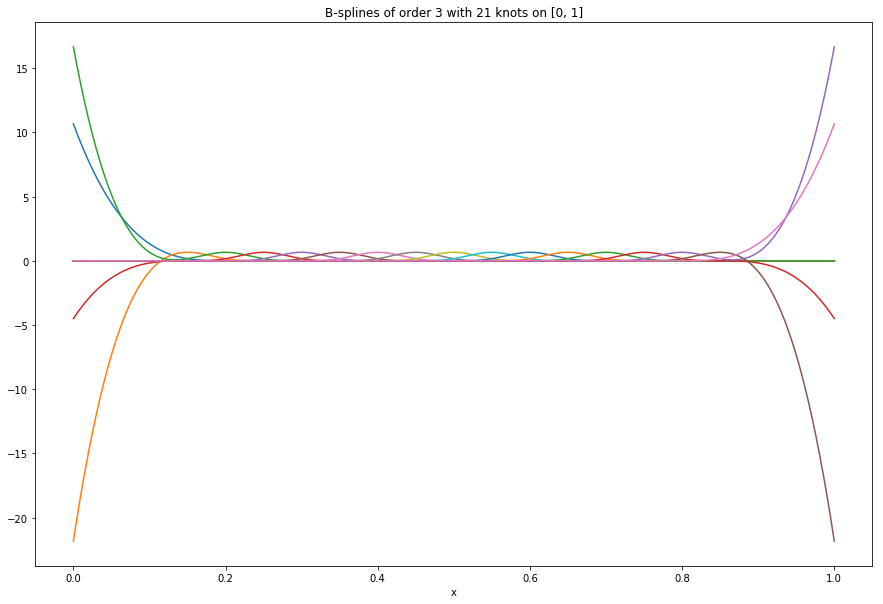

In [146]:
plt.figure(figsize=(15, 10))
x_for_plot = np.linspace(0, 1, 1000)

m = 3 # order of b-splines
K = 20 # number of spans

knots = np.linspace(0, 1, K + 1)
coef = np.identity(K - m) # each row is coefficients of linear combination of b-splines
for c in coef:
    bspl = BSpline(t=knots, c=c, k=m)
    plt.plot(x_for_plot, bspl(x))
plt.title('B-splines of order 3 with 21 knots on [0, 1]')
plt.xlabel('x')